In [1]:
import pandas as pd

In [2]:
# Loading Data Set

loan_df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
loan_df

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler


In [4]:
# Spliting the data into features and target
X = loan_df.drop(['default','customer_id'], axis=1)
y = loan_df['default']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into traning and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Teain the Logistic Regression model
log_reg.fit(X_train, y_train)

#Predict probabilities of default
probabilities = log_reg.predict_proba(X_test)[:,1]
probabilities

array([8.34142458e-08, 9.80342518e-03, 9.99999926e-01, ...,
       7.36163767e-09, 7.88599746e-08, 7.99863262e-08], shape=(3000,))

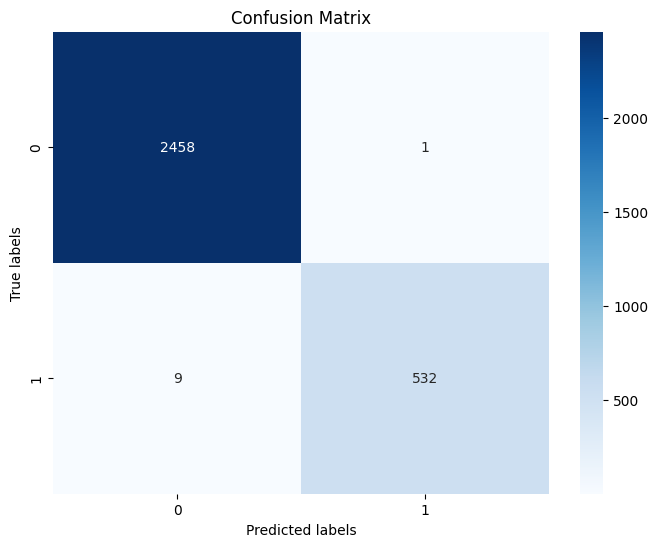

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the class labels for the test set
y_pred = log_reg.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Get Coefficients

# Get the feature names from Dataframe
feature_names = X.columns

# Get the coefficients from the model
coefficients = log_reg.coef_[0]

# Create a Dataframe with a feature names and coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Print out the sorted features
coeff_df.sort_values(by = 'Coefficient', ascending=False)


,Feature,Coefficient
0,credit_lines_outstanding,8.518931
2,total_debt_outstanding,3.685591
1,loan_amt_outstanding,0.145166
5,fico_score,-1.175821
3,income,-2.315660
4,years_employed,-2.768698


In [16]:
# Logistic Regression expected loss function 

def calculate_expected_loss(model, scaler, features, recovery_rate= 0.1):
    '''
    Calculate the expected los for a loan 
    Parameters
    ----------
    - model : The trained logistic regression model.
    - scaler: The StandardScaler instance used to scale the training data.
    - features : A list or array of features for the individual borrower. Order if Features:
         ['credit_line_outstanding', loand_amt_outstanding', 'total_dept_outstanding', 'income', 'years_employed',fico_score']
    - recovery_rate : The recovery rate in the event of default.

    Returns:
    - expected_loss : The expected loss for the loan.
    '''

    # Scale the features using the provided scaler
    features_scaled = scaler.transform([features])

    # Predict the probability of default
    probability_of_default = model.predict_proba(features_scaled)[:,1][0]

    # Calculate the expected loss
    LGD = 1 - recovery_rate # Loss Given Default

    #Exposure At Default is the loan_amt_outstanding - note that this is the feature BEFORE scaling
    EAD = features[1]
    expected_loss = probability_of_default * EAD * LGD

    return expected_loss

# Test a borrower's features
borrower_features = [5,1958.928726, 8228.752520, 26648.43524,2,572]

# Calculate the expected loss for this borrower
borrower_expected_loss = calculate_expected_loss(log_reg,scaler,borrower_features)
print('Borrowers expected loss:',borrower_expected_loss)

Borrowers expected loss: 1763.035141694681


c:\Users\tanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


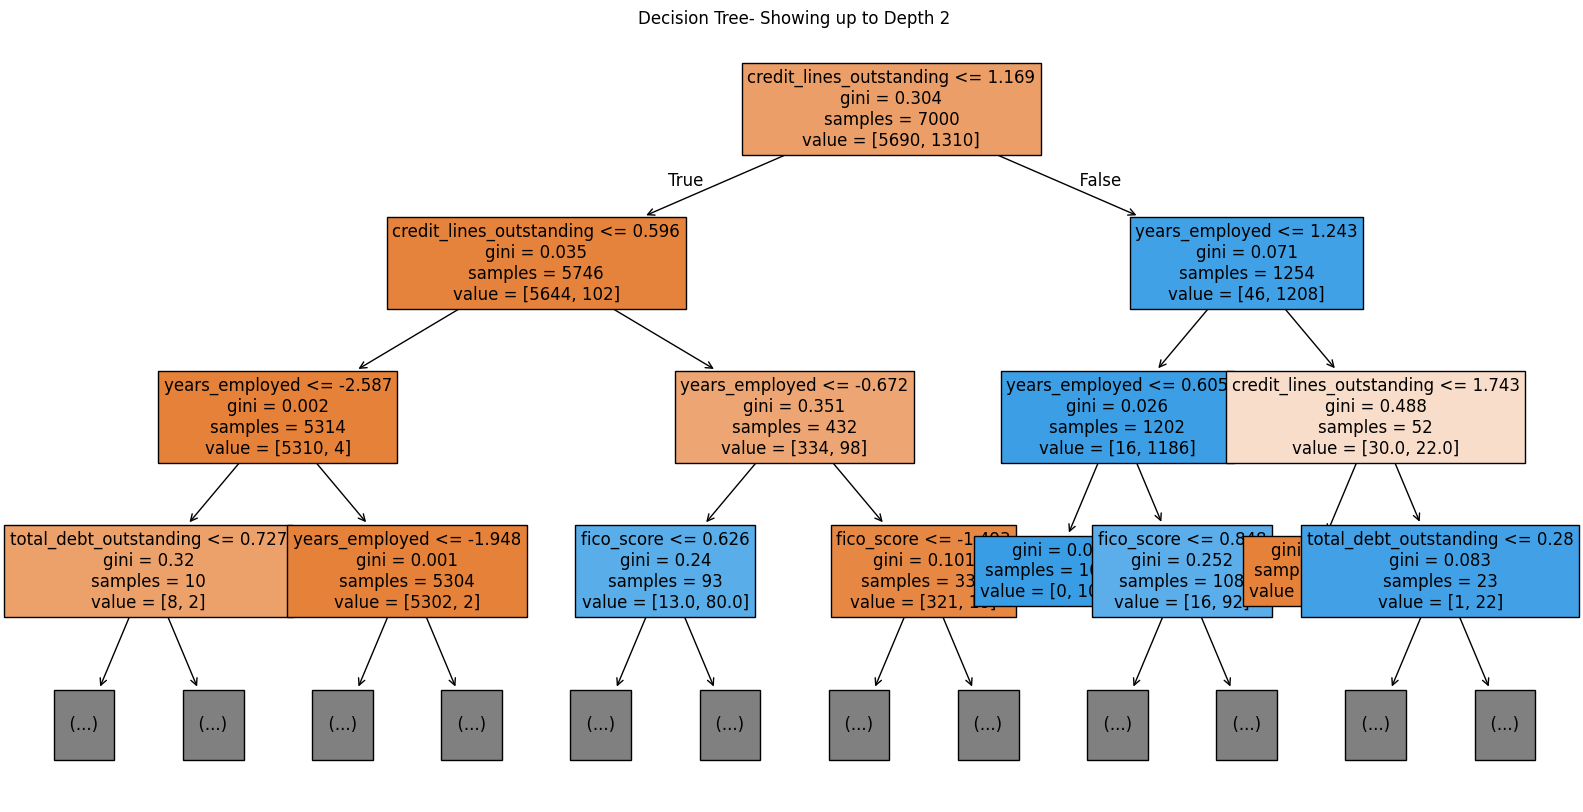

In [18]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

#Train the Decision tree model
decision_tree.fit(X_train,y_train)

# Plot the top of the decision tree
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled= True, feature_names=feature_names, max_depth=3, fontsize=12)
plt.title('Decision Tree- Showing up to Depth 2')
plt.show()

In [24]:
# Extract information of tree
n_nodes = decision_tree.tree_.node_count
children_left = decision_tree.tree_.children_left
children_right = decision_tree.tree_.children_right
feature = decision_tree.tree_.feature
threshold = decision_tree.tree_.threshold

# Get the ids of the leaf nodes
leaf_ids = [node_id for node_id, left_child in enumerate(children_left) if left_child == -1]

# Initilize an empty list to hold lead info
leaf_samples = []

# Iterate over each leaf node
for leaf_id in leaf_ids:
    samples = decision_tree.tree_.value[leaf_id,0]
    leaf_samples.append(samples)

# Now leaf_samples contains the counts of [Class_0, Class_1]  for all the leaves
leaf_samples

[array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([0., 1.]),
 array([1., 0.]),
 array([1., 0.]),
 array([0., 1.])]

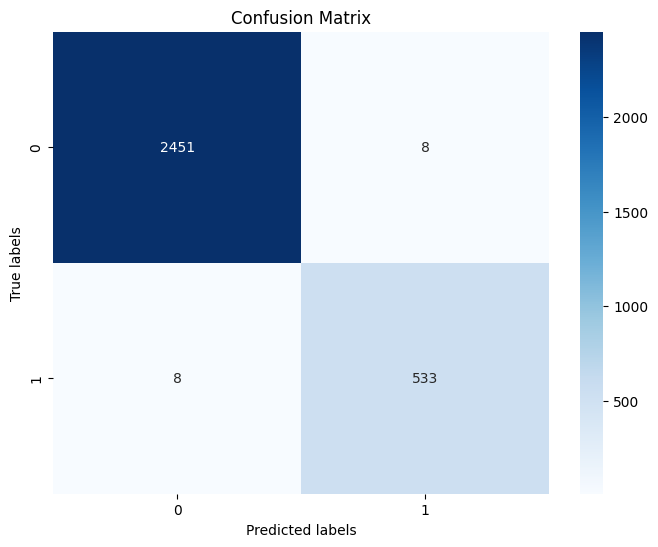

In [25]:
# We get a slightly more balanced result than the logistic regression output

#Predict the class labels for the test set
y_pred2 = decision_tree.predict(X_test)

# Compute the confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred2)

# plot the confustion matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix2, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Test a borrower's features
borrower_features = [5,1958.928726, 8228.752520, 26648.43524,2,572]

# Testing using Decision Tree
borrower_expected_loss = calculate_expected_loss(decision_tree,scaler,borrower_features)
print('Borrowers expected loss:',borrower_expected_loss)

Borrowers expected loss: 1763.0358534000002


c:\Users\tanis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the predicted probabilities for the logistic regression model
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_prob)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_prob)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred_prob)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.011570114305372537
Mean Squared Error (MSE): 0.0035488135881694737
R-squared (R²): 0.9759912304541052
